# The Adjoint Method

In this notebook, we will go through the process of implementing the adjoint method for computing gradients arising from a numerical integration.

In [1]:
import typing
import warnings

import math
import torch
import einops
import neuralode

warnings.simplefilter('ignore', RuntimeWarning)

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cpu')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float64)

We'll be starting with the same function from the previous notebook, but we have tidied up the code by using `neuralode.util.partial_compensated_sum` to track the truncated bits instead of duplicating the code through our integration function.

In [3]:
def get_integrator(integrator_tableau: torch.Tensor, integrator_order: int, use_local_extrapolation: bool = True, integrator_name: str = None) -> torch.autograd.Function:
    # We look at the first column of the last two rows, and if both are `inf`, we know the method is adaptive
    is_adaptive = torch.isinf(integrator_tableau[-1,0]) and torch.isinf(integrator_tableau[-2,0])
    # The number of stages is the number of rows minus the last row
    # (or last two rows if the method is adaptive)
    number_of_stages = integrator_tableau.shape[0] - 1
    if is_adaptive:
        number_of_stages -= 1
    # The `type` function in this form works to dynamically create a class
    # the first parameter is the class name, the second are parent classes,
    # and the last are the class attributes. We store the integrator attributes 
    # here, and reference them in the integration code.
    # In this way, we can query these parameters at a future point.
    __integrator_type = type(integrator_name, (torch.autograd.Function,), {
        "integrator_tableau": integrator_tableau,
        "integrator_order": integrator_order,
        "is_adaptive": is_adaptive,
        "number_of_stages": number_of_stages
    })
    def __internal_forward(ctx, fn: typing.Callable[[torch.Tensor, torch.Tensor, typing.Any], torch.Tensor], 
                           x0: torch.Tensor, t0: torch.Tensor, t1: torch.Tensor, dt: torch.Tensor,
                           atol: torch.Tensor, rtol: torch.Tensor, *additional_dynamic_args):
        """
        A general integration routine for solving an Initial Value Problem
        using any arbitrary Butcher Tableau
        
        Instead of naively summing the changes, we use compensated summation.
        
        :param fn: the function to be integrated
        :param initial_state: the initial state to integrate from
        :param initial_time: the initial time to integrate from
        :param final_time: the final time to integrate to
        :param timestep: the time increments to integrate with
        :param atol: The absolute tolerance for the error in an adaptive integration
        :param rtol: The relative tolerance for the error in an adaptive integration
        :param additional_dynamic_args: additional arguments to pass to the function
        :return: a tuple of ((the final state, the final time), the intermediate states [list[torch.Tensor]], the error values [list[torch.Tensor]]) 
        """
        if __integrator_type.is_adaptive:
            atol = torch.abs(atol) # Need to ensure that the tolerance is a strictly positive number
            if atol.dim() != 0:
                try:
                    _ = x0.clone() + atol.clone()
                except RuntimeError:
                    raise ValueError(f"Expected shape of x0 and atol to be compatible, got {x0.shape} and {atol.shape} respectively")
            # 
            if torch.any((atol < torch.finfo(x0.dtype).eps) & (atol != 0.0)):
                warnings.warn(f"Absolute tolerance is too small for tensor dtype: {x0.dtype}. Set atol={torch.finfo(x0.dtype).eps}.", RuntimeWarning)
                atol = torch.where((atol < torch.finfo(x0.dtype).eps) & (atol != 0.0), (atol/atol.detach())*torch.finfo(x0.dtype).eps, atol) 
            elif torch.any(atol < torch.finfo(x0.dtype).eps**0.5):
                warnings.warn(f"Absolute tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error", RuntimeWarning)
            rtol = torch.abs(rtol) # Need to ensure that the tolerance is a strictly positive number
            if rtol.dim() != 0:
                try:
                    _ = x0.clone() + rtol.clone()
                except RuntimeError:
                    raise ValueError(f"Expected shape of x0 and rtol to be compatible, got {x0.shape} and {rtol.shape} respectively")
            # 
            if torch.any((rtol < torch.finfo(x0.dtype).eps) & (rtol != 0.0)):
                warnings.warn(f"Relative tolerance is too small for tensor dtype: {x0.dtype}. Set rtol={torch.finfo(x0.dtype).eps}.", RuntimeWarning)
                rtol = torch.where((rtol < torch.finfo(x0.dtype).eps) & (rtol != 0.0), (rtol/rtol.detach())*torch.finfo(x0.dtype).eps, rtol) 
            elif torch.any(rtol < torch.finfo(x0.dtype).eps**0.5):
                warnings.warn(f"Relative tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error", RuntimeWarning)
        
        if torch.any(torch.abs(t1 - t0) < torch.abs(dt)):
            dt = (t1 - t0)
        
        if torch.any(torch.sign(t1 - t0) != torch.sign(dt)):
            warnings.warn(f"Different sign of (t1 - t0) and dt: {t1 - t0} and {dt}, correcting...", RuntimeWarning)
            dt = torch.copysign(dt, t1 - t0) 
            
        dt = dt.clone()
            
        min_step_size = (t1 - t0)*torch.finfo(dt.dtype).resolution
        
        c_state = x0.clone()
        c_time = t0.clone()
        
        intermediate_states = [c_state.clone()]
        intermediate_times = [c_time.clone()]
        
        butcher_tableau = __integrator_type.integrator_tableau.clone().to(x0.device, x0.dtype)
        error_in_state = [torch.zeros(tuple(), device=x0.device, dtype=x0.dtype)]
            
        k_stages = torch.stack([torch.zeros_like(c_state)]*__integrator_type.number_of_stages)
        
        def compute_step(state, time, step):
            for stage_index in range(__integrator_type.number_of_stages):
                c_coeff, *a_coeff = butcher_tableau[stage_index]
                k_stages[stage_index] = fn(
                    # We use `compensated_sum` instead of `sum` to avoid truncation at each stage calculation
                    state + step * neuralode.util.compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                    time + c_coeff * step,
                    *additional_dynamic_args
                ) 
            lower_order_estimate = step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:]))
            higher_order_estimate = lower_order_estimate
            if __integrator_type.is_adaptive:
                higher_order_estimate = step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-2, 1:]))
            return lower_order_estimate, higher_order_estimate, step
        
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(c_state)
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(c_time)
        
        while torch.any(torch.where(t1 > t0, (c_time + dt) < t1, (c_time - dt) > t1)):
            delta_state_lower, delta_state_upper, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, dt)
            delta_state = delta_state_upper if use_local_extrapolation else delta_state_lower

            error_in_state.append(torch.linalg.norm(delta_state_upper - delta_state_lower))
            if __integrator_type.is_adaptive:
                max_error = atol + torch.linalg.norm(rtol * c_state)
                step_correction = 0.8*torch.where(error_in_state[-1] != 0.0, max_error/error_in_state[-1], 1.0)**(1/integrator_order)
                torch.copysign(torch.maximum(torch.abs(min_step_size), torch.abs(step_correction.detach()*dt)), dt, out=dt)
                if error_in_state[-1].detach() >= max_error.detach():
                    error_in_state = error_in_state[:-1]
                    continue
            c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
            c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
            intermediate_states.append(c_state + truncated_bits_state)
            intermediate_times.append(c_time + truncated_bits_time)
            
        delta_state_lower, delta_state_upper, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, (t1 - c_time) - truncated_bits_time)
        delta_state = delta_state_upper if use_local_extrapolation else delta_state_lower
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
        c_state = c_state + truncated_bits_state
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
        c_time = c_time + truncated_bits_time
            
        error_in_state.append(torch.linalg.norm(delta_state_upper - delta_state_lower))
        
        intermediate_states.append(c_state.clone())
        intermediate_times.append(c_time.clone())
        
        intermediate_states = torch.stack(intermediate_states, dim=0)
        intermediate_times = torch.stack(intermediate_times, dim=0)
        
        error_in_state = torch.stack(error_in_state, dim=0)
        
        if ctx is not None:
            non_differentiable_parameters = [dt]
            backward_save_variables = [x0, t0, t1, dt, c_state, c_time, intermediate_states, intermediate_times, *additional_dynamic_args]
            if __integrator_type.is_adaptive:
                non_differentiable_parameters = non_differentiable_parameters + [atol, rtol]
                backward_save_variables = [atol, rtol] + backward_save_variables
            ctx.mark_non_differentiable(*non_differentiable_parameters)
            ctx.save_for_backward(*backward_save_variables)
            ctx.__integration_fn = fn
        
        return c_state, c_time, intermediate_states, intermediate_times, error_in_state.detach()
    
    def __internal_backward(ctx, d_c_state, d_c_time, d_intermediate_states, d_intermediate_times, d_error_in_state):
        """
        This function computes the gradient of the input variables for `__internal_forward` by exploiting the fact
        that PyTorch can track the whole graph of operations used to derive a specific result. Thus each time backward is called,
        we compute the actual graph of operations and propagate derivatives through it. Unfortunately, this is an exceptionally
        slow method of computation that also uses a lot of memory.
        
        This is implemented here as a demonstration of how we could compute gradients and how these are expected to be propagated back
        to the autograd tape. 
        
        :param ctx: 
        :param d_c_state: 
        :param d_c_time: 
        :param d_intermediate_states: 
        :param d_intermediate_times: 
        :param d_error_in_state: 
        :return: 
        """
        
        # First, we retrieve our integration function that we stored in `__internal_forward`
        fn = ctx.__integration_fn
        
        # Then we retrieve the input variables
        if __integrator_type.is_adaptive:
            atol, rtol, x0, t0, t1, dt, c_state, c_time, intermediate_states, intermediate_times, *additional_dynamic_args = [i for i in ctx.saved_tensors]
            tol_args = [atol, rtol]
        else:
            x0, t0, t1, dt, c_state, c_time, intermediate_states, intermediate_times, *additional_dynamic_args = [i for i in ctx.saved_tensors]
            atol, rtol = torch.inf, torch.inf
            tol_args = []
            
        inputs = fn, x0, t0, t1, dt, atol, rtol, *additional_dynamic_args
        input_grads = [None for _ in range(len(inputs))]
        
        if any(ctx.needs_input_grad):
            # We ensure that gradients are enabled so that autograd tracks the variable operations
            # For pointwise functionals, the initial adjoint state is simply the incoming gradients
            additional_dynamic_args = [i.detach().clone().requires_grad_(True) for i in additional_dynamic_args]
            for i in additional_dynamic_args:
                i.grad = torch.zeros_like(i)
            parameter_shapes = [i.shape for i in additional_dynamic_args]
            packed_reverse_state = torch.cat([
                c_state.ravel(),
                d_c_state.ravel(),
                # d_c_time.detach().clone().ravel(),
            ]).detach()
            if len(additional_dynamic_args) > 0:
                packed_reverse_state = torch.cat([
                    packed_reverse_state,
                    torch.zeros(sum(map(math.prod, parameter_shapes)), device=c_state.device, dtype=c_state.dtype)
                ])
            # Construct the adjoint equation
            def __adjoint_integration_fn(packed_state, adj_time, *ignored_parameters):
                # Unpack the state variables
                state = packed_state[:c_state.numel()].reshape(c_state.shape).clone().requires_grad_(True)
                time = adj_time.detach().clone().requires_grad_(True)
                adj_lagrange = packed_state[c_state.numel():2*c_state.numel()].reshape(c_state.shape)
                # adj_omega = packed_state[2*c_state.numel():2*c_state.numel()+1]
                # parameter_states = packed_state[2*c_state.numel()+1:]
                
                with torch.set_grad_enabled(True):
                    for i in additional_dynamic_args:
                        i.grad *= 0.0
                    dy = fn(state, time, *additional_dynamic_args).ravel()
                    # We want the product of the jacobian of dy/dt wrt. each of the parameters multiplied by the adjoint variables
                    # This is the Jacobian-vector product which can be directly computed through PyTorch autograd using the backward function
                    # and passing the adjoint variables.
                    dy.backward(adj_lagrange)
                    
                    # The alternative is to compute the jacobian explicitly and then do the product, but this requires
                    # multiple passes through the autodiff graph which is inefficient. Instead, the above achieves
                    # the same result in one pass instead of one pass per variable (4 variables in this case)
                    
                    # state_derivatives_of_ode = neuralode.util.jacobian(dy, state)
                    # time_derivatives_of_ode = neuralode.util.jacobian(dy, time)
                    
                    # adj_lagrange_derivatives = einops.einsum(adj_lagrange, state_derivatives_of_ode, "i,i ...->...").ravel()
                    # adj_omega_derivatives = -einops.einsum(adj_omega, time_derivatives_of_ode, "i,i...->...").ravel()
                    
                    # parameter_derivatives_of_ode = [
                    #     neuralode.util.jacobian(dy, i) for i in all_parameters
                    #     ]
                    # 
                    # parameter_derivatives_of_ode = torch.cat([
                    #     einops.einsum(adj_lagrange, i, "i,i ...->...").ravel() for i in parameter_derivatives_of_ode
                    #     ], dim=0)
                    
                    adj_lagrange_derivatives = state.grad
                    
                dadj = torch.cat([
                    dy.detach(),
                    -adj_lagrange_derivatives.detach(), 
                    # adj_omega_derivatives.detach(), 
                    ], dim=0)
                if len(additional_dynamic_args) > 0:
                    parameter_derivatives_of_ode = torch.cat([i.grad.ravel() for i in additional_dynamic_args])
                    dadj = torch.cat([
                        dadj,
                        -parameter_derivatives_of_ode
                        ])
                return dadj
            
            current_adj_time = t1.detach().clone()
            current_adj_state = packed_reverse_state 
            
            if torch.any(d_intermediate_states != 0.0):
                for next_adj_time, d_inter_state in zip(intermediate_times[1:-1].flip(dims=[0]), d_intermediate_states[1:-1].flip(dims=[0])):
                    if torch.all(d_inter_state == 0.0):
                        continue
                    current_adj_state, current_adj_time, _, _, _ = __integrator_type.apply(__adjoint_integration_fn, current_adj_state, current_adj_time, next_adj_time, -dt, *tol_args, *additional_dynamic_args)
                    current_adj_state[c_state.numel():2*c_state.numel()] += d_inter_state.ravel()
            
            final_adj_state, final_adj_time, _, _, _ = __integrator_type.apply(__adjoint_integration_fn, current_adj_state, current_adj_time, t0, -dt, *tol_args, *additional_dynamic_args)
            
            adj_variables = final_adj_state[c_state.numel():2*c_state.numel()].reshape(c_state.shape)
            adj_parameter_gradients = final_adj_state[2*c_state.numel():]
            input_grads[1] = adj_variables
            input_grads[2] = -einops.einsum(adj_variables.ravel(), fn(x0, t0, *additional_dynamic_args).ravel(), "i,i->")
            input_grads[3] = d_c_time.detach() + einops.einsum(d_c_state.ravel(), fn(c_state, c_time, *additional_dynamic_args).ravel(), "i,i->")
            
            parameter_gradients = []
            
            for p_shape, num_elem in zip(parameter_shapes, map(math.prod, parameter_shapes)): 
                parameter_gradients.append(None)
                adj_parameter_gradients, parameter_gradients[-1] = adj_parameter_gradients[num_elem:], adj_parameter_gradients[:num_elem].reshape(p_shape)
            
            input_grads[7:] = parameter_gradients
            
            if not __integrator_type.is_adaptive:
                input_grads = input_grads[:5] + input_grads[7:]
        return tuple(input_grads)
            
    
    if not __integrator_type.is_adaptive:
        # If the method isn't adaptive, neither atol nor rtol are required, but because of
        # how `torch.autograd.Function` works, we cannot have keyword arguments
        # For that reason, we use an alternative implementation to fill those values with a stub
        def __internal_forward_nonadaptive(ctx, fn: typing.Callable[[torch.Tensor, torch.Tensor, typing.Any], torch.Tensor], 
                                           x0: torch.Tensor, t0: torch.Tensor, t1: torch.Tensor, dt: torch.Tensor, *additional_dynamic_args):
            return __internal_forward(ctx, fn, x0, t0, t1, dt, torch.inf, torch.inf, *additional_dynamic_args)
        __integrator_type.forward = staticmethod(__internal_forward_nonadaptive)
    else:
        __integrator_type.forward = staticmethod(__internal_forward)
    __integrator_type.backward = staticmethod(__internal_backward)
    return __integrator_type

In [4]:
initial_position = torch.tensor(1.0)
initial_velocity = torch.tensor(0.0)

frequency = (torch.ones_like(initial_position)).requires_grad_(True)
damping = (torch.ones_like(initial_position)*0.25).requires_grad_(True)
initial_state = torch.stack([
    initial_position,
    initial_velocity,
], dim=-1).requires_grad_(True)

initial_time = torch.tensor(0.0).requires_grad_(True)
final_time   = torch.tensor(25.0).requires_grad_(True)

initial_timestep = (final_time - initial_time) / 100

adaptive_rk45_integrator = get_integrator(torch.tensor([
    [0.0,       0.0,         0.0,        0.0,         0.0,      0.0,          0.0,      0.0 ],
    [1/5,       1/5,         0.0,        0.0,         0.0,      0.0,          0.0,      0.0 ],
    [3/10,      3/40,        9/40,       0.0,         0.0,      0.0,          0.0,      0.0 ],
    [4/5,       44/45,      -56/15,      32/9,        0.0,      0.0,          0.0,      0.0 ],
    [8/9,       19372/6561, -25360/2187, 64448/6561, -212/729,  0.0,          0.0,      0.0 ],
    [1.0,       9017/3168,  -355/33,     46732/5247,  49/176,  -5103/18656,   0.0,      0.0 ],
    [1.0,       35/384,      0.0,        500/1113,    125/192, -2187/6784,    11/84,    0.0 ],
    [torch.inf, 35/384,      0.0,        500/1113,    125/192, -2187/6784,    11/84,    0.0 ],
    [torch.inf, 5179/57600,  0.0,        7571/16695,  393/640, -92097/339200, 187/2100, 1/40]
], dtype=torch.float64), integrator_order = 5, integrator_name = "AdaptiveRK45Integrator")

atol = rtol = torch.tensor(5e-8)

In [5]:
final_state, _, sha_states, sha_times, _ = adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, atol, rtol, frequency, damping)

The Jacobian is a good indicator of the derivatives and specifically relates to the sensitivity of the output with respect to the input. We can compute it by creating a function that simply returns our trajectory and then using the `pytorch.autograd` functional API.

In [6]:
def compute_trajectory_return_final_state(x, t0):
    return adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, x, t0, final_time, initial_timestep, atol, rtol, frequency, damping)[0][0]

def compute_trajectory_return_intermediate_state(x, t0):
    return adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, x, t0, final_time, initial_timestep, atol, rtol, frequency, damping)[2][3][0]

jac_wrt_initial_state, jac_wrt_initial_time = torch.autograd.functional.jacobian(compute_trajectory_return_final_state, (initial_state.clone(), initial_time.clone()))
print(f"The Jacobian of x(t1) wrt. x(t0) is: {jac_wrt_initial_state.cpu().numpy()}")
print(f"The Jacobian of x(t1) wrt. t0 is: {jac_wrt_initial_time.cpu().numpy()}")

jac_wrt_initial_state, jac_wrt_initial_time = torch.autograd.functional.jacobian(compute_trajectory_return_intermediate_state, (initial_state.clone(), initial_time.clone()))
print(f"The Jacobian of x({sha_times[3].item():.4e}) wrt. x(t0) is: {jac_wrt_initial_state.cpu().numpy()}")
print(f"The Jacobian of x({sha_times[3].item():.4e}) wrt. t0 is: {jac_wrt_initial_time.cpu().numpy()}")

The Jacobian of x(t1) wrt. x(t0) is: [ 0.00076099 -0.001594  ]
The Jacobian of x(t1) wrt. t0 is: -0.0015940001305334052
The Jacobian of x(4.0285e-01) wrt. x(t0) is: [0.92558778 0.35394913]
The Jacobian of x(4.0285e-01) wrt. t0 is: 0.35394912787548916


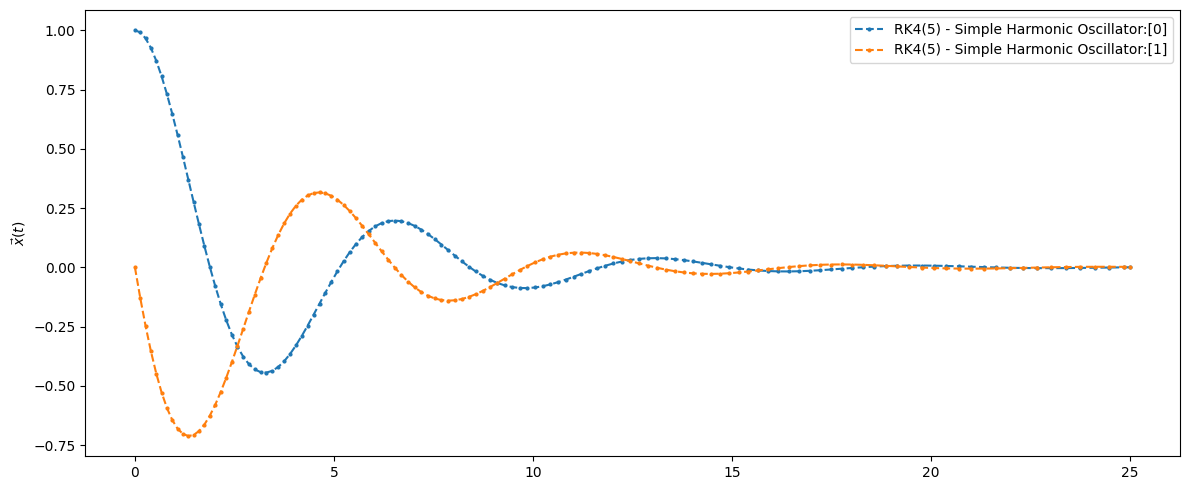

In [7]:
fig, axes = neuralode.plot.trajectory.plot_trajectory([(i, j) for i, j in zip(sha_states, sha_times)], method_label="RK4(5) - Simple Harmonic Oscillator")

In [ ]:
from torch.autograd import gradcheck

def test_func(init_state, integration_t0, integration_t1, freq, damp):
    res = adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, init_state, integration_t0, integration_t1, atol.clone(), atol**2, rtol**2, freq, damp)
    return res[0]

test_variables = [initial_state, initial_time, final_time, frequency, damping]

def generate_test_vars():
    test_t0 = torch.rand_like(initial_time) - 1.0
    test_t1 = torch.rand_like(final_time)*final_time
    test_x = torch.rand_like(initial_state)
    test_frequency = torch.rand_like(frequency)*5.0
    test_damping = torch.rand_like(damping)
    return [i.requires_grad_(True) for i in [test_x, test_t0, test_t1, test_frequency, test_damping]]

num_tests = 16
print(f"[0/{num_tests}] - vars: {[i.detach().cpu().tolist() for i in test_variables]}, success: ", end='')
print(gradcheck(test_func, [i.detach().clone().requires_grad_(True) for i in test_variables]))
for iter_idx in range(num_tests):
    variables = generate_test_vars()
    print(f"[{iter_idx+1}/{num_tests}] - vars: {[i.detach().cpu().tolist() for i in variables]}, success: ", end='')
    print(gradcheck(test_func, variables))

In [8]:
with torch.no_grad():
    _, _, sha_states_ref, sha_times_ref, _ = adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, atol, rtol, frequency, damping)
sha_states_ref, sha_times_ref = sha_states_ref.detach(), sha_times_ref.detach()

In [9]:
state_dataset = sha_states_ref.clone()
time_dataset  = sha_times_ref.clone()
# We skip the first time as we know the initial state

# We reinitialise our variables
optimised_frequency = torch.tensor(0.1, requires_grad=True)
optimised_damping = torch.tensor(1.0, requires_grad=True)
# As damping needs to be a strictly positive quantity, we log-encode it
log_encoded_damping = torch.log(optimised_damping.detach()).requires_grad_(True)

# First, we'll create an `optimiser` following pytorch convention
optimiser = torch.optim.Adam([optimised_frequency, log_encoded_damping], lr=1e-1, amsgrad=True)

# Next, we'll define a closure function whose sole purpose is to
# zero the gradients and compute the error. This is useful as it allows switching to other
# optimisers such as LBFGS or anything that re-evaluates the error without
# computing its gradient
def sha_closure(minibatch):
    current_state = initial_state.detach().clone()
    current_time  = initial_time.detach().clone()
    optimiser.zero_grad()
    error = 0.0
    
    times = minibatch['times']
    states = minibatch['states']
    
    # We need to sort both times and states simultaneously, so we'll use `argsort`
    sorted_time_indices = torch.argsort(times)
    times, states = times[sorted_time_indices], states[sorted_time_indices]
    
    for sample_state, sample_time in zip(states, times):
        dt = torch.minimum(initial_timestep, sample_time - current_time).detach()
        new_state, new_time, _, _, _ = adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, current_state, current_time, sample_time, dt, atol, rtol, optimised_frequency, torch.exp(log_encoded_damping))
        error = error + torch.linalg.norm(sample_state - new_state)/times.shape[0]
        current_state, current_time = new_state, new_time
    if error.requires_grad:
        error.backward()
    return error

# We need to set the size of our mini-batches
batch_size = 16

# Now we need an optimisation `loop` where we will take steps to minimise the error
number_of_gd_steps = 256*batch_size//time_dataset.shape[0]

# We also need to track the best solution thus far
best_error = torch.inf
best_frequency, best_damping = optimised_frequency.detach().clone(), optimised_damping.detach().clone()
for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(time_dataset.shape[0])
    for batch_idx in range(0, time_dataset.shape[0], batch_size):
        batch_dict = {
            'times': time_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: sha_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['times'].shape[0]
        print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{time_dataset.shape[0]}] Batch Error: {step_error:.6f}, Current Frequency: {optimised_frequency.item():.4f}, Current Damping: {torch.exp(log_encoded_damping).item():.4f}", end='\r')
    epoch_error = epoch_error/time_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_frequency = optimised_frequency.detach().clone()
        best_damping = torch.exp(log_encoded_damping.detach().clone())
    print(" "*128, end="\r")
    print(f"[{step+1}/{number_of_gd_steps}] Epoch Error: {epoch_error:.6f}, Current Frequency: {optimised_frequency.item():.6f}, Current Damping: {torch.exp(log_encoded_damping).item():.6f}")

print(f"Best frequency: {best_frequency.item():.6f}, relative error: {torch.mean(torch.abs(1 - best_frequency / frequency)).item():.6%}")
print(f"Best damping:   {best_damping.item():.6f}, relative error: {torch.mean(torch.abs(1 - best_damping / damping)).item():.6%}")

[1/33] Epoch Error: 0.414591, Current Frequency: 0.708246, Current Damping: 0.541017                                            
[2/33] Epoch Error: 0.134296, Current Frequency: 1.076267, Current Damping: 0.321754                                            
[3/33] Epoch Error: 0.083784, Current Frequency: 1.105058, Current Damping: 0.262267                                            
[4/33] Epoch Error: 0.048544, Current Frequency: 0.935906, Current Damping: 0.268713                                            
[5/33] Epoch Error: 0.032866, Current Frequency: 1.027090, Current Damping: 0.254296                                            
[6/33] Epoch Error: 0.018044, Current Frequency: 1.021598, Current Damping: 0.241082                                            
[7/33] Epoch Error: 0.011749, Current Frequency: 1.009100, Current Damping: 0.247670                                            
[8/33] Epoch Error: 0.010854, Current Frequency: 1.025352, Current Damping: 0.239649             

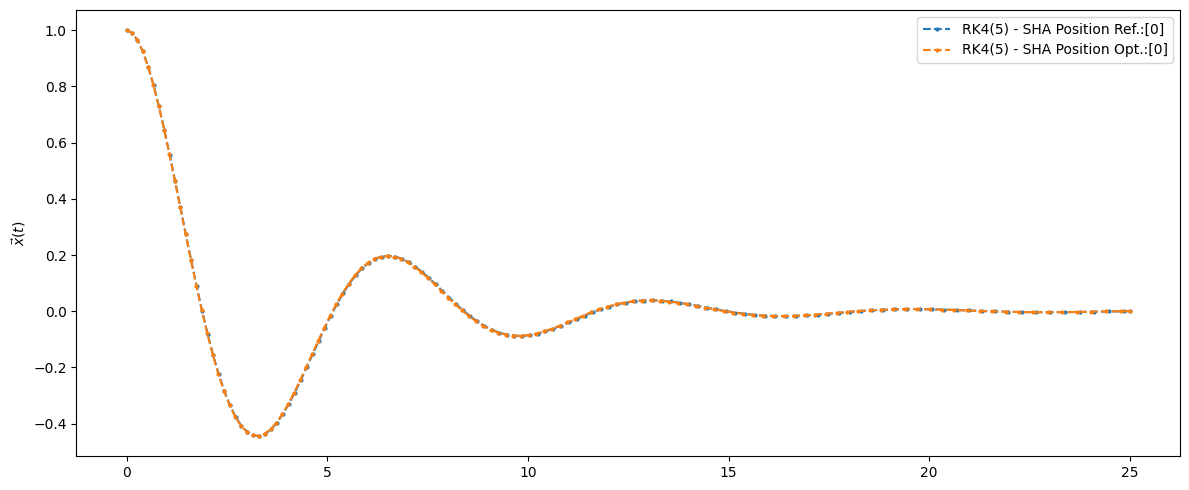

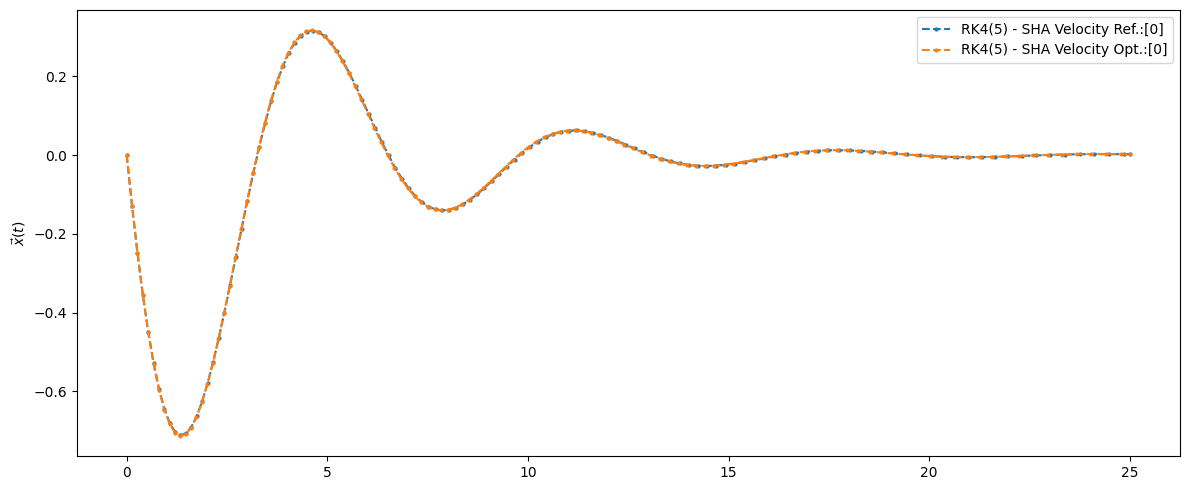

In [10]:
fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Position Ref.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Velocity Ref.")

_, _, sha_states_optimised, sha_times_optimised, _ = adaptive_rk45_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, atol, rtol, best_frequency, best_damping)
_ = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_position, method_label="RK4(5) - SHA Position Opt.")
_ = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_velocity, method_label="RK4(5) - SHA Velocity Opt.")

Now let's add a neural network into the mix! Okay, well, this will be the simplest network possible aka a matrix multiplied with the input vector. While this may seem simple, you'll see that our simple harmonic oscillator is expressed as a matrix multiplied by the input with a very specific structure that arises from the fact that it was a second order equation. I've written this matrix below:

$$
\begin{bmatrix}
    x^{(1)} \\
    v^{(1)}
\end{bmatrix} = 
\mathbf{A}
\begin{bmatrix}
    x \\
    v
\end{bmatrix}
$$

where

$$
\mathbf{A} =
\begin{bmatrix}
    0 & 1 \\
    -\omega^2 & -2\zeta\omega
\end{bmatrix}
$$

Given that matrix multiplication underlies most neural networks, we can try to learn this $\mathbf{A}\textrm{-matrix}$ and at the same time introduce some of the Neural Network machinery in PyTorch. We will revisit these later when learning more interesting/complex systems.

In [15]:
state_dataset = sha_states_ref.clone()
time_dataset  = sha_times_ref.clone()

# we define our network as a subclass of torch.nn.Module
# This allows PyTorch to appropriately track parameters
class OscillatorNet(torch.nn.Module):
    def __init__(self):
        # First we initialise the superclass, `torch.nn.Module`
        super().__init__()
        # Then we define the actual neural network
        # Most Neural Networks operate sequentially so they can be wrapped
        # inside a torch.nn.Sequential which takes each layer
        # as an argument.
        # Since we're only learning one matrix, we have
        # one layer, the `torch.nn.Linear`.
        # `torch.nn.Linear` stores a matrix and a bias which actually makes it
        # an Affine transformation rather than a purely linear transformation
        self.internal_net = torch.nn.Sequential(
            torch.nn.Linear(2, 2),
        )
    
    def forward(self, x, t):
        # Our network only depends on x, but since it could also depend on t, we have
        # included it for completeness
        # Additionally, PyTorch layers and modules expect a batched tensor
        # ie. a tensor where the first dimension is over different samples
        # Since we don't depend on batches, we check if the input is 1-dimensional
        # And add a batch dimension as needed for the internal module
        if x.dim() == 1:
            return self.internal_net(x[None])[0]
        else:
            return self.internal_net(x)

# Here we instantiate our network.
simple_oscillator_net = OscillatorNet()
# And then instantiate the weights of the network itself
def init_weights(m):
    # For each layer type, we can define how we initialise its values
    if isinstance(m, torch.nn.Linear):
        # A linear equation with a positive coefficient
        # translates to exponential growth and a negative coefficient
        # to exponential decay. In order to preserve stability we sample a matrix
        # that is biased to be negative in its entries thus ensuring
        # that our initial system is of exponential decay.
        m.weight.data.normal_(-0.1, 0.1)
        if m.bias is not None:
            m.bias.data.normal_(0.0, 0.1)
simple_oscillator_net.apply(init_weights)

# `torch.autograd.Function`s track computation on all input tensors.
# For that reason, we must pass our neural network parameters to the integrator,
# which will pass it to the derivative function.
# Since our network is stateful, we don't use these parameters, but define them in 
# the function signature.
def sha_nn_fn(x, t, *nn_parameters):
    return simple_oscillator_net(x, t)

optimiser = torch.optim.Adam(simple_oscillator_net.parameters(), lr=1e-2, amsgrad=True)

def sha_closure(minibatch):
    current_state = initial_state.detach().clone()
    current_time  = initial_time.detach().clone()
    optimiser.zero_grad()
    error = 0.0
    
    times = minibatch['times']
    states = minibatch['states']
    
    sorted_time_indices = torch.argsort(times)
    times, states = times[sorted_time_indices], states[sorted_time_indices]
    
    for sample_state, sample_time in zip(states, times):
        dt = torch.minimum(initial_timestep, sample_time - current_time).detach()
        current_state, current_time, _, _, _ = adaptive_rk45_integrator.apply(sha_nn_fn, current_state, current_time, sample_time, dt, atol, rtol, *simple_oscillator_net.parameters())
        error = error + torch.linalg.norm(sample_state - current_state)/times.shape[0]
    if error.requires_grad:
        error.backward()
    return error

ideal_matrix = neuralode.dynamics.get_simple_harmonic_oscillator_matrix(frequency, damping)
ideal_bias = torch.zeros_like(initial_state)

batch_size = 16

# Now we need an optimisation `loop` where we will take steps to minimise the error. 
# We don't know how many steps are required to "train" this network, so we start with a large number
number_of_gd_steps = 128

best_error = torch.inf
# For pytorch modules, the `state_dict` method allows us to get a copy
# of all the parameters that define the model, thus enabling us to 
# store the state as well as restore it.
best_parameters = simple_oscillator_net.state_dict()
for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(time_dataset.shape[0])
    for batch_idx in range(0, time_dataset.shape[0], batch_size):
        batch_dict = {
            'times': time_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: sha_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['times'].shape[0]
        learned_matrix = list(simple_oscillator_net.parameters())[0]
        learned_bias = list(simple_oscillator_net.parameters())[1]
        print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{time_dataset.shape[0]}] Batch Error: {step_error:.6f} ", end='\r')
    epoch_error = epoch_error/time_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_parameters = simple_oscillator_net.state_dict()
    print(" "*128, end="\r")
    # Ideally our matrix is equivalent to our simple harmonic oscillator matrix and our bias goes to zero
    print(f"[{step+1}/{number_of_gd_steps}] Epoch Error: {epoch_error:.6f}, \nW={list(simple_oscillator_net.parameters())[0]}, \nb={list(simple_oscillator_net.parameters())[1]}")
    
simple_oscillator_net.load_state_dict(best_parameters)
learned_matrix = list(simple_oscillator_net.parameters())[0]
learned_bias = list(simple_oscillator_net.parameters())[1]

# Before we were looking at relative error, but in the case of a matrix with zeros,
# the relative error is undefined so we look at a more common metric: mean squared error
print(f"Best matrix: {learned_matrix}, mean square error: {torch.mean(torch.square(ideal_matrix - learned_matrix)).item():.6f}")
print(f"Best bias:   {learned_bias}, mean square error: {torch.mean(torch.square(ideal_bias - learned_bias)).item():.6f}")

[1/128] Epoch Error: 0.447072,                                                                                                  
W=Parameter containing:
tensor([[-0.1945, -0.1851],
        [-0.1263, -0.2971]], requires_grad=True), 
b=Parameter containing:
tensor([-0.0623,  0.0446], requires_grad=True)
[2/128] Epoch Error: 0.365630,                                                                                                  
W=Parameter containing:
tensor([[-0.2219, -0.1532],
        [-0.1142, -0.3244]], requires_grad=True), 
b=Parameter containing:
tensor([-0.0491,  0.0184], requires_grad=True)
[3/128] Epoch Error: 0.301097,                                                                                                  
W=Parameter containing:
tensor([[-0.2480, -0.1303],
        [-0.1072, -0.3421]], requires_grad=True), 
b=Parameter containing:
tensor([-0.0267, -0.0102], requires_grad=True)
[4/128] Epoch Error: 0.280350,                                                             

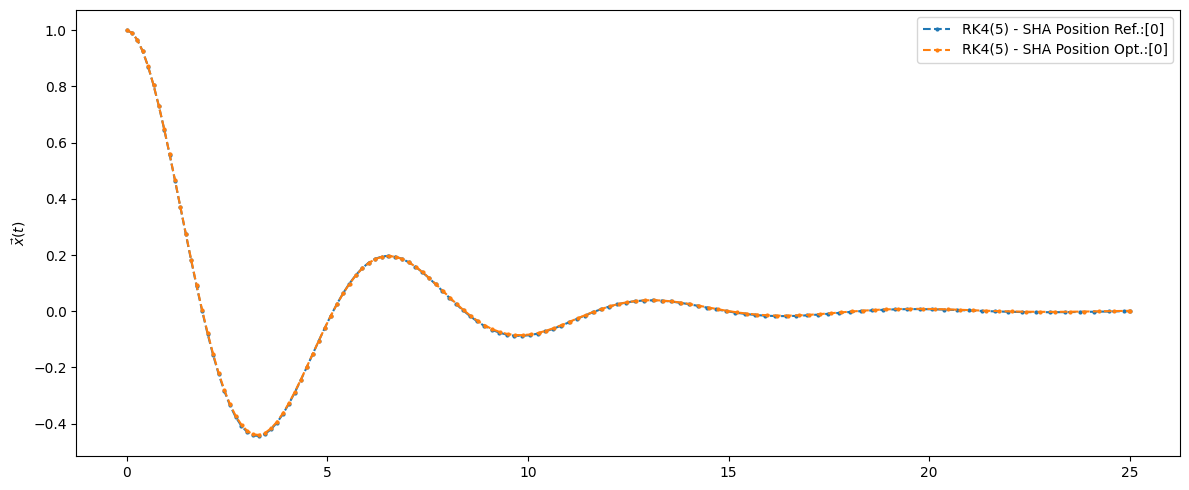

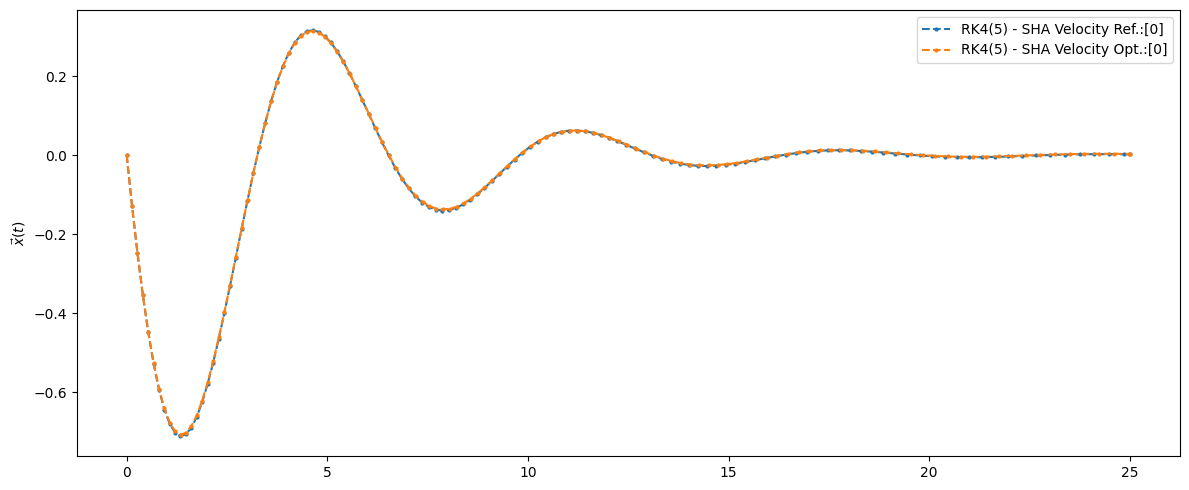

In [16]:
fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Position Ref.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Velocity Ref.")

simple_oscillator_net.load_state_dict(best_parameters)
_, _, sha_states_optimised, sha_times_optimised, _ = adaptive_rk45_integrator.apply(sha_nn_fn, initial_state, initial_time, final_time, initial_timestep, atol, rtol, best_frequency, best_damping)
_ = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_position, method_label="RK4(5) - SHA Position Opt.")
_ = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_velocity, method_label="RK4(5) - SHA Velocity Opt.")

And we can see that the neural network is able to effectively learn the dynamics of this system, but it would not extend to other systems with different frequency and damping as they would have a different matrix.

In the coming notebooks, we will extend our network to learn the general dynamics by passing frequency and damping as a parameter.